In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import tension
%load_ext autoreload
%autoreload 2

from tension.spiking import LIF_OptimizedFORCE, SpikingNNModel_OptimizedFORCE
from tension.callbacks import VoltageTracking

import time
import numpy as np
import tensorflow as tf

from fbm import FBM 
from scipy import signal

print(tf.__version__)

2.7.0


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'ticks')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
EXTRA_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=EXTRA_SIZE)  # fontsize of the figure title

In [4]:
class CustomSpikingNNModel(SpikingNNModel_OptimizedFORCE):
    def __init__(self, step=50, **kwargs):
        super().__init__(**kwargs)
        self.num_step = tf.Variable(0., trainable=False)
        self.step = step

    def update_kernel_condition(self):
        self.num_step.assign_add(1.0, read_value=False)
        return self.num_step % self.step == 0

In [ ]:
def generate_data_incre_average(T, dt, T_on, T_signal, T_in_out_delay, fbm_f, input_smooth):

    ts = fbm_f.fbm()
    ts = ts[1:]
    ts_smooth = signal.savgol_filter(x=ts, window_length=input_smooth, polyorder=3)
    ts_cumsum_mean = ts_smooth.cumsum() / np.arange(1,int(T_signal/dt)+1)

    inputs = np.zeros((round(T / dt), 1)).astype(np.float32)
    outputs = np.zeros((round(T / dt), 1)).astype(np.float32)

    inputs[int(T_on/dt):int(T_on/dt+T_signal/dt),0] = ts_smooth
    outputs[int(T_on/dt+T_in_out_delay/dt):int(T_on/dt+T_in_out_delay/dt+T_signal/dt),0] = ts_cumsum_mean
    
    return inputs, outputs

def generate_data_diff(T, dt, T_on, T_signal, T_in_out_delay, fbm_f, win_size, tau, input_smooth):

    ts = fbm_f.fbm()
    ts = ts[1:]
    ts_smooth = signal.savgol_filter(x=ts, window_length=input_smooth, polyorder=3)
    ts_diff = np.diff(ts_smooth)
    
    win = signal.windows.exponential(M=win_size+1, center=0, tau=tau, sym=False)
    ts_diff_filtered = signal.convolve(ts_diff, win, mode='valid') / sum(win)
    ts_diff_filtered_padded = np.pad(ts_diff_filtered, (win_size, 0), 'constant') # pad with zero at the beginning

    inputs = np.zeros((round(T / dt), 1)).astype(np.float32)
    outputs = np.zeros((round(T / dt), 1)).astype(np.float32)
    
    inputs[int(T_on/dt):int(T_on/dt+T_signal/dt),0] = ts_smooth
    outputs[int(T_on/dt+T_in_out_delay/dt)+1:int(T_on/dt+T_in_out_delay/dt+T_signal/dt),0] = ts_diff_filtered_padded
    
    return inputs, outputs


def generate_data_delay(T, dt, T_on, T_signal, T_in_out_delay, fbm_f, input_smooth):

    ts = fbm_f.fbm()
    ts = ts[1:]
    ts_smooth = signal.savgol_filter(x=ts, window_length=input_smooth, polyorder=3)
    
    inputs = np.zeros((round(T / dt), 1)).astype(np.float32)
    outputs = np.zeros((round(T / dt), 1)).astype(np.float32)

    inputs[int(T_on/dt):int(T_on/dt+T_signal/dt),0] = ts_smooth
    outputs[int(T_on/dt+T_in_out_delay/dt):int(T_on/dt+T_in_out_delay/dt+T_signal/dt),0] = ts_smooth
    
    return inputs, outputs



In [6]:
''' training setting '''
N = 1000 # number of neurons
n_samples = 1000 # number of train samples
steps = 50 # number of steps to update kernels
p_recurr = 1 # (1 - p_recurr) of recurrent weights are randomly set to 0
nepochs = 1 # number of epochs
win_size, tau = 125, 30 # params for the exponential filter of differentiation output
input_smooth = 75

T, dt = 5, 0.005

''' LIF neuron parameters '''
tau_ref = 0.002 # refractory time constant
tau_mem = 0.01 # membrane time constant
v_reset = -65 # reset voltage
v_peak = -40 # peak voltage
tau_decay = 0.02 # decay time constant
tau_rise = 0.002 # rise time constant
tau_syn = tau_decay # synaptic time constant
alpha = dt # gain on P matrix at initialization
Q = 10 # scales the feedback kernel
G = 0.04 # scales the static recurrent kernel
I_bias = -40 # bias current

g = 1.0 # gain parameter controlling network chaos

print('Number of timesteps: ', T/dt)


Number of timesteps:  1000.0


In [7]:
random_seed_list_np = np.array([0,10,20,30,40,50,60,70,80,90])
random_seed_list_tf = np.array([0,10,20,30,40,50,60,70,80,90]) + 100
random_seed_list_layer = np.array([0,10,20,30,40,50,60,70,80,90]) + 200

model_index = 0

np.random.seed(random_seed_list_np[model_index])
tf.random.set_seed(random_seed_list_tf[model_index])

# Integration task

In [8]:
# generate samples for training

T_on, T_signal, T_in_out_delay = 0.5, 4, 0

input_list, hint_list, target_list = [], [], []

fbm_f = FBM(n=int(T_signal/dt), hurst=0.5)

for i in range(n_samples): 
    
    inputs, targets = generate_data_incre_average(T, dt, T_on, T_signal, T_in_out_delay, fbm_f, input_smooth)
    
    input_list.append(tf.expand_dims(inputs, axis=0))
    target_list.append(tf.expand_dims(targets, axis=0))
    
inputs_integral = tf.concat(input_list, axis=0)
targets_integral = tf.concat(target_list, axis=0)
m = targets_integral.shape[-1]

assert inputs_integral.shape == targets_integral.shape
print('Target shape: ', targets_integral.shape)
print('Target output dimension: ', m)
# print(np.mean(target))
print(inputs_integral.shape, targets_integral.shape)


2023-07-20 05:38:25.034006: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 05:38:26.093580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30155 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0
2023-07-20 05:38:26.094306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22511 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:b1:00.0, compute capability: 7.5


Target shape:  (1000, 1000, 1)
Target output dimension:  1
(1000, 1000, 1) (1000, 1000, 1)


In [10]:
%%time

LIF_layer_integral = LIF_OptimizedFORCE(units=N,
                output_size=m,
                dt=dt,
                tau_decay=tau_decay,
                tau_rise=tau_rise,
                tau_syn=tau_syn,
                tau_ref=tau_ref,
                tau_mem=tau_mem,
                v_peak=v_peak,
                v_reset=v_reset,
                I_bias=I_bias,
                G=G,
                Q=Q,
                p_recurr=p_recurr,
                g=g,
                seed=random_seed_list_layer[model_index])
spikingmodel_integral = CustomSpikingNNModel(force_layer=LIF_layer_integral,
                                    alpha_P=alpha,
                                    step=steps)
spikingmodel_integral.compile(metrics=["mae"])

print(LIF_layer_integral._input_kernel_trainable,\
     LIF_layer_integral._recurrent_kernel_trainable,\
     LIF_layer_integral._output_kernel_trainable)

history = spikingmodel_integral.fit(x=inputs_integral, y=targets_integral, epochs=nepochs)
# LIF_layer_integral.recurrent_kernel

False True True
1000000/1000000 [==============================] - 3783s 4ms/step - mae: 0.1479
CPU times: user 2h 10min 25s, sys: 16min 8s, total: 2h 26min 33s
Wall time: 1h 3min 3s


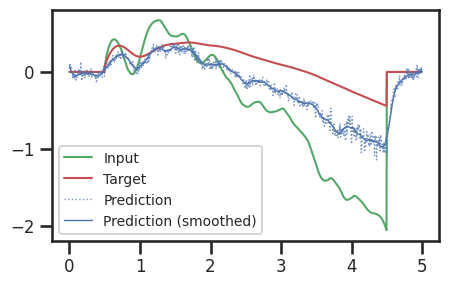

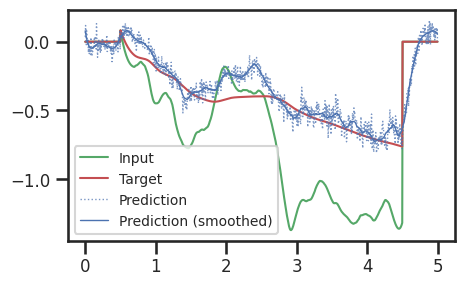

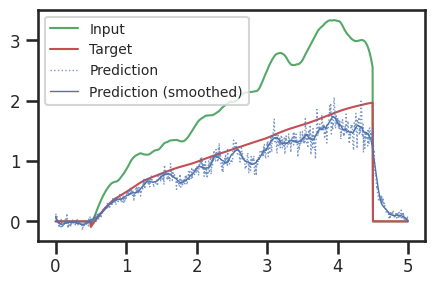

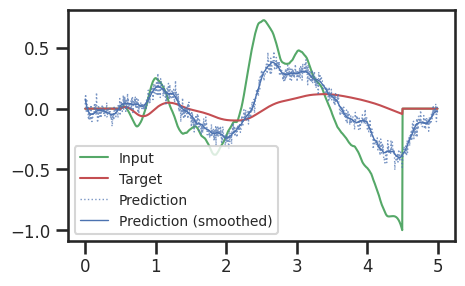

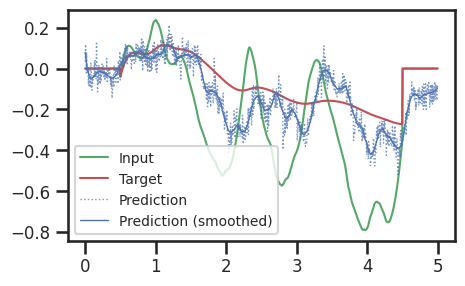

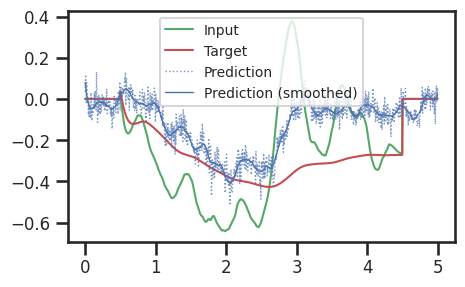

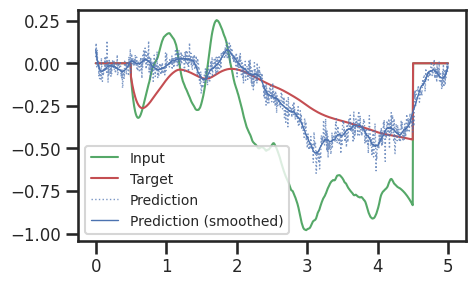

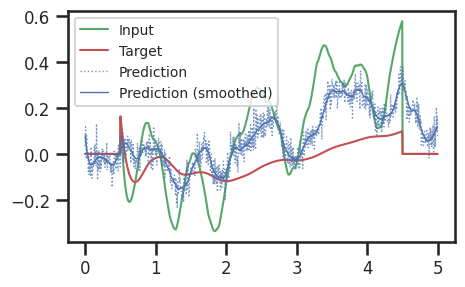

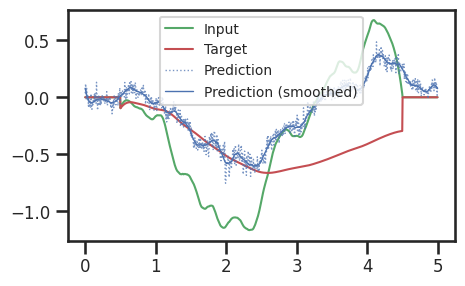

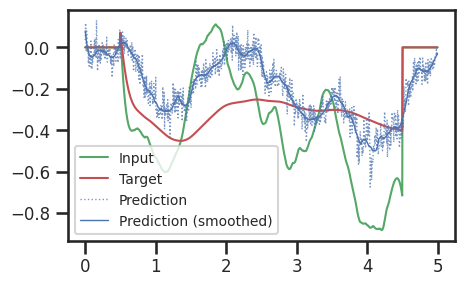

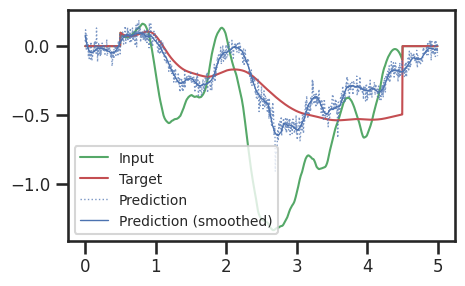

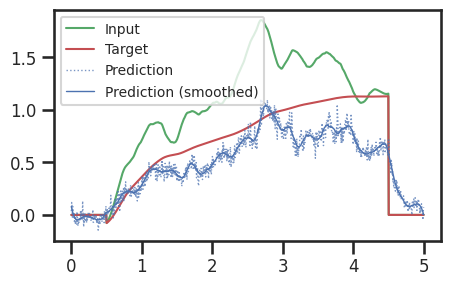

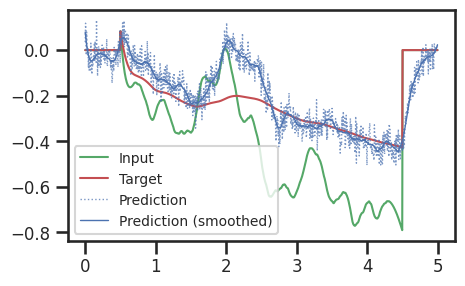

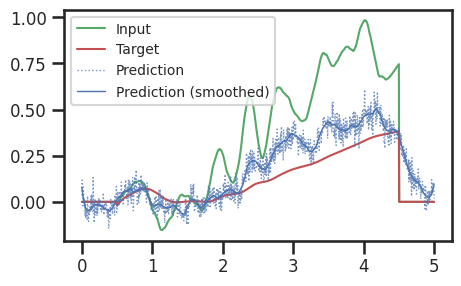

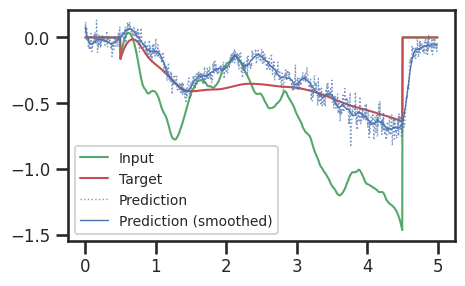

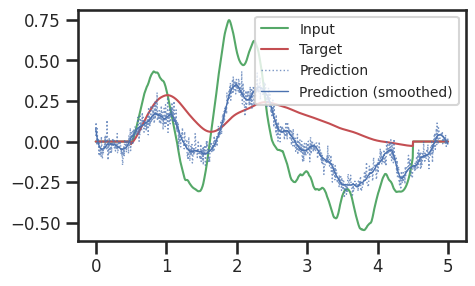

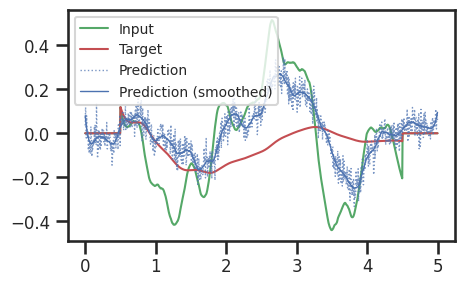

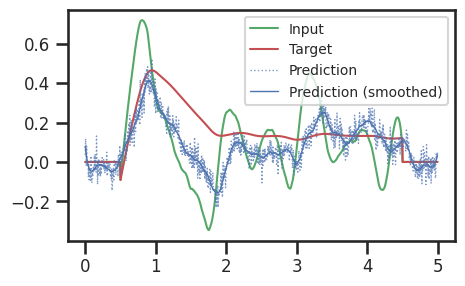

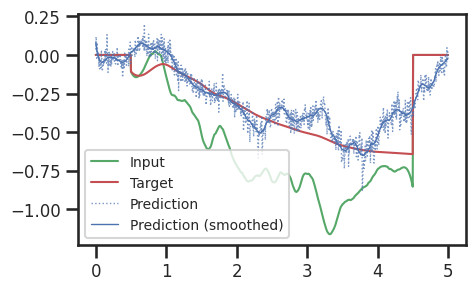

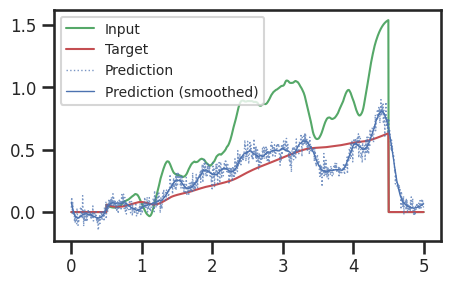

In [11]:
''' training performance '''
x = np.arange(0, targets_integral[0].shape[0]) * dt

for idx in range(0,200,10):
    plt.figure(figsize=(5,3))
    
    prediction = spikingmodel_integral.predict(inputs_integral[idx])
    pred_smooth = signal.savgol_filter(x=prediction[:,0], window_length=steps+1, polyorder=3)
    
    plt.plot(x, inputs_integral[idx], color='g', label='Input', linewidth=1.5)
    plt.plot(x, targets_integral[idx], color='r', label='Target', linewidth=1.5)
    plt.plot(x, prediction, color='b',label='Prediction', linewidth=1, alpha=0.75, linestyle=":")
    plt.plot(x, pred_smooth, color='b',label='Prediction (smoothed)', linewidth=1)
    
    plt.legend()
#     plt.yticks([0, 1])
    plt.show()


In [14]:
# generate samples for training

T_on, T_signal, T_in_out_delay = 0.5, 4, 0

input_list, hint_list, target_list = [], [], []

fbm_f = FBM(n=int(T_signal/dt), hurst=0.5)

for i in range(n_samples): 
    
    inputs, targets = generate_data_diff(T, dt, T_on, T_signal, T_in_out_delay, fbm_f, win_size, tau, input_smooth)
    
    input_list.append(tf.expand_dims(inputs, axis=0))
    target_list.append(tf.expand_dims(targets, axis=0))
    
inputs_diff = tf.concat(input_list, axis=0)
targets_diff = tf.concat(target_list, axis=0)
m = targets_diff.shape[-1]

assert inputs_diff.shape == targets_diff.shape
print('Target shape: ', targets_diff.shape)
print('Target output dimension: ', m)
# print(np.mean(target))
print(inputs_diff.shape, targets_diff.shape)


Target shape:  (1000, 1000, 1)
Target output dimension:  1
(1000, 1000, 1) (1000, 1000, 1)


In [ ]:
%%time

LIF_layer_diff = LIF_OptimizedFORCE(units=N,
                output_size=m,
                dt=dt,
                tau_decay=tau_decay,
                tau_rise=tau_rise,
                tau_syn=tau_syn,
                tau_ref=tau_ref,
                tau_mem=tau_mem,
                v_peak=v_peak,
                v_reset=v_reset,
                I_bias=I_bias,
                G=G,
                Q=Q,
                p_recurr=p_recurr,
                g=g,
                seed=random_seed_list_layer[model_index])
spikingmodel_diff = CustomSpikingNNModel(force_layer=LIF_layer_diff,
                                    alpha_P=alpha,
                                    step=steps)
spikingmodel_diff.compile(metrics=["mae"])

print(LIF_layer_diff._input_kernel_trainable,\
     LIF_layer_diff._recurrent_kernel_trainable,\
     LIF_layer_diff._output_kernel_trainable)

history = spikingmodel_diff.fit(x=inputs_diff, y=targets_diff, epochs=nepochs)

False True True
1000000/1000000 [==============================] - 3818s 4ms/step - mae: 0.0025
CPU times: user 2h 11min 14s, sys: 16min 7s, total: 2h 27min 21s
Wall time: 1h 3min 38s


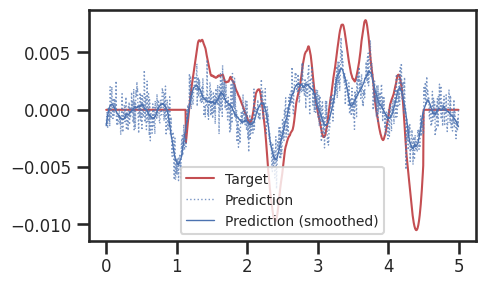

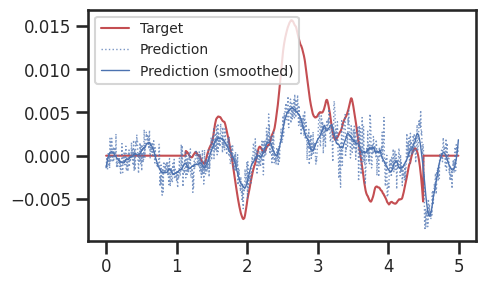

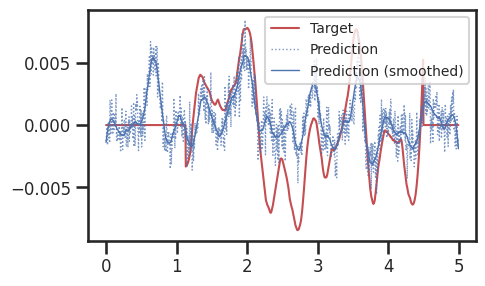

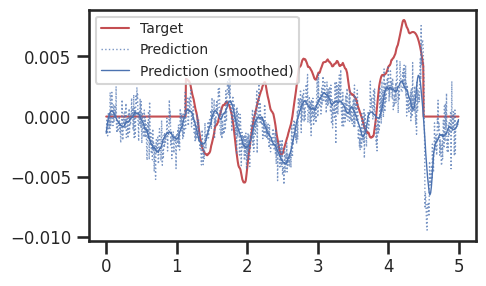

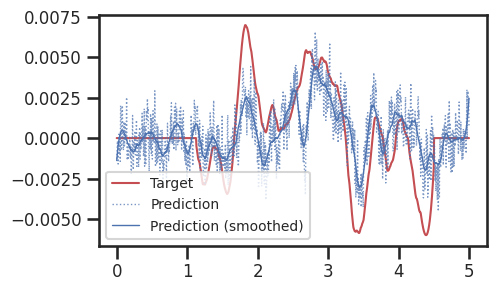

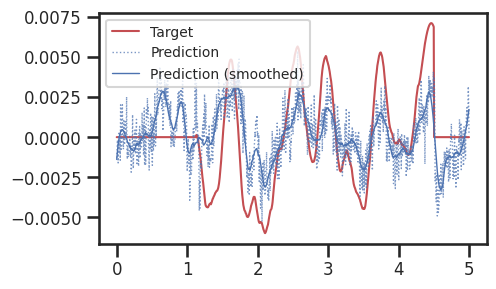

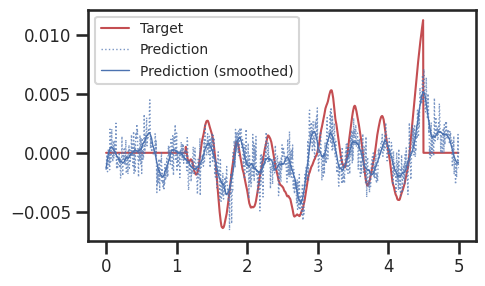

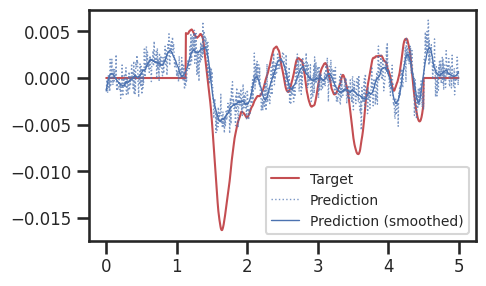

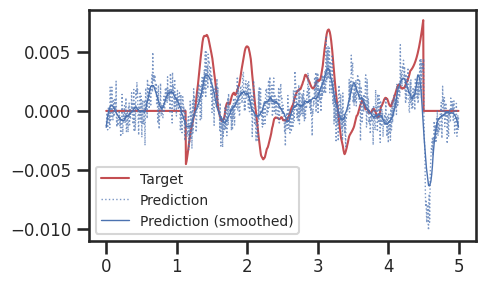

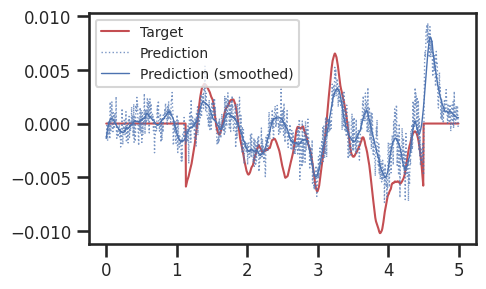

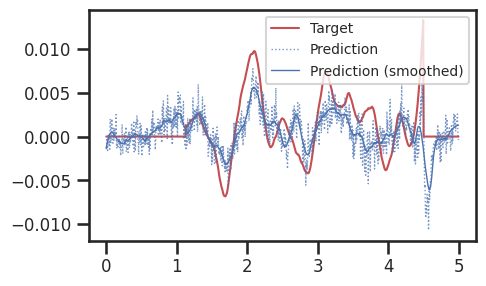

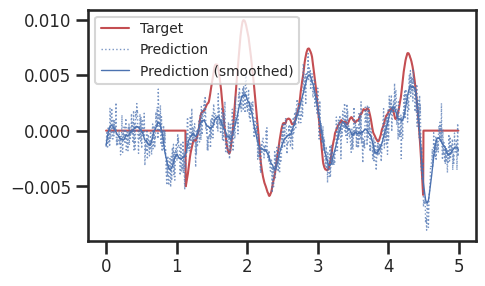

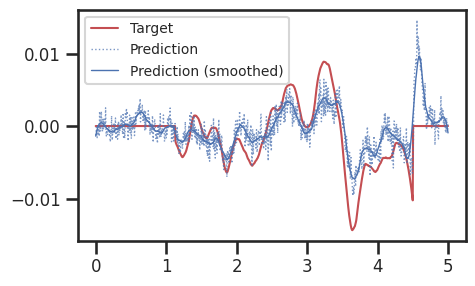

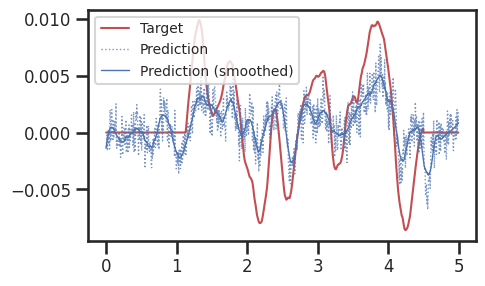

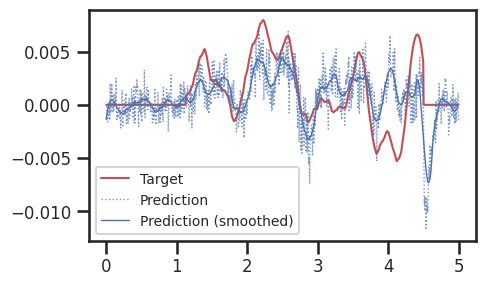

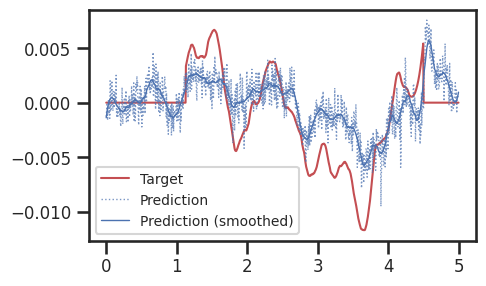

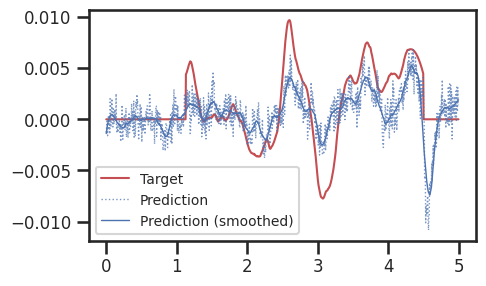

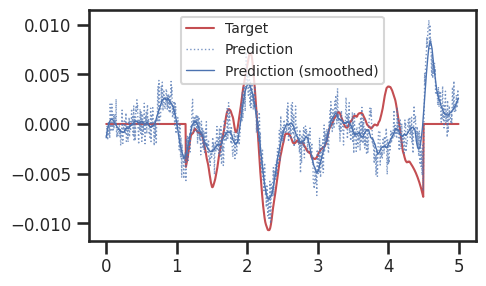

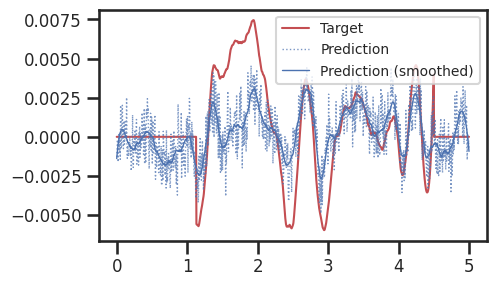

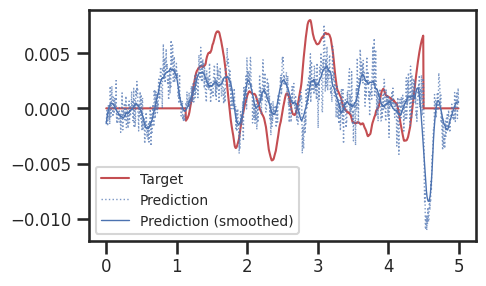

In [ ]:
''' training performance '''

x = np.arange(0, targets_diff[0].shape[0]) * dt

for idx in range(0,200,10):
    plt.figure(figsize=(5,3))
    
    prediction = spikingmodel_diff.predict(inputs_diff[idx])
    pred_smooth = signal.savgol_filter(x=prediction[:,0], window_length=steps+1, polyorder=3)
    
    plt.plot(x, targets_diff[idx], color='r', label='Target', linewidth=1.5)
    plt.plot(x, prediction, color='b',label='Prediction', linewidth=1, alpha=0.75, linestyle=":")
    plt.plot(x, pred_smooth, color='b',label='Prediction (smoothed)', linewidth=1)

    plt.legend()
    plt.show()


# Delay task

In [ ]:
# generate samples for training

T_on, T_signal, T_in_out_delay = 0.5, 4, 0.5

input_list, hint_list, target_list = [], [], []

fbm_f = FBM(n=int(T_signal/dt), hurst=0.5)

for i in range(n_samples): 
    
    inputs, targets = generate_data_delay(T, dt, T_on, T_signal, T_in_out_delay, fbm_f, input_smooth)
    
    input_list.append(tf.expand_dims(inputs, axis=0))
    target_list.append(tf.expand_dims(targets, axis=0))
    
inputs_delay = tf.concat(input_list, axis=0)
targets_delay = tf.concat(target_list, axis=0)
m = targets_delay.shape[-1]

assert inputs_delay.shape == targets_delay.shape
print('Target shape: ', targets_delay.shape)
print('Target output dimension: ', m)
print(inputs_delay.shape, targets_delay.shape)


Target shape:  (1000, 1000, 1)
Target output dimension:  1
(1000, 1000, 1) (1000, 1000, 1)


In [ ]:
%%time

LIF_layer_delay = LIF_OptimizedFORCE(units=N,
                output_size=m,
                dt=dt,
                tau_decay=tau_decay,
                tau_rise=tau_rise,
                tau_syn=tau_syn,
                tau_ref=tau_ref,
                tau_mem=tau_mem,
                v_peak=v_peak,
                v_reset=v_reset,
                I_bias=I_bias,
                G=G,
                Q=Q,
                p_recurr=p_recurr,
                g=g,
                seed=random_seed_list_layer[model_index])
spikingmodel_delay = CustomSpikingNNModel(force_layer=LIF_layer_delay,
                                    alpha_P=alpha,
                                    step=steps)
spikingmodel_delay.compile(metrics=["mae"])

print(LIF_layer_delay._input_kernel_trainable,\
     LIF_layer_delay._recurrent_kernel_trainable,\
     LIF_layer_delay._output_kernel_trainable)

history = spikingmodel_delay.fit(x=inputs_delay, y=targets_delay, epochs=nepochs)

False True True
1000000/1000000 [==============================] - 3816s 4ms/step - mae: 0.2425
CPU times: user 2h 11min 16s, sys: 16min 5s, total: 2h 27min 21s
Wall time: 1h 3min 36s


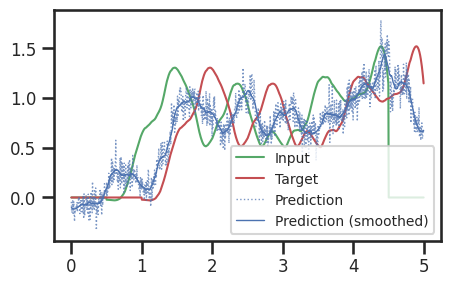

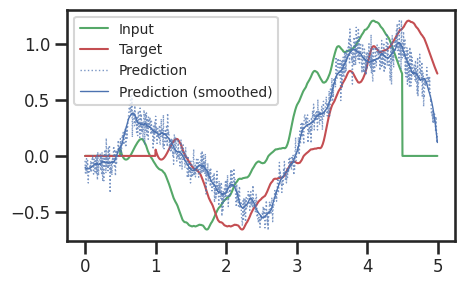

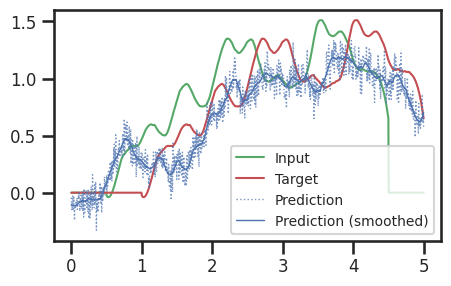

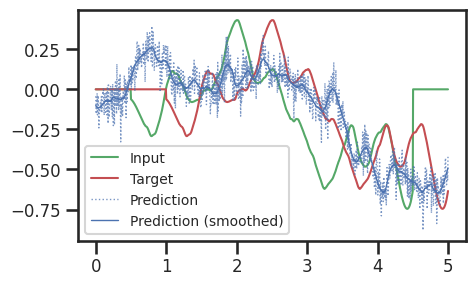

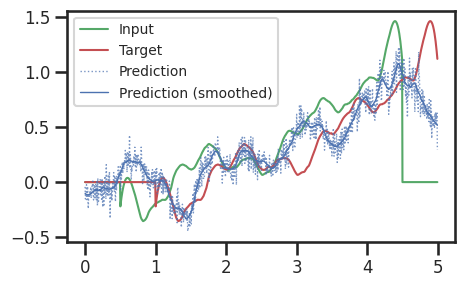

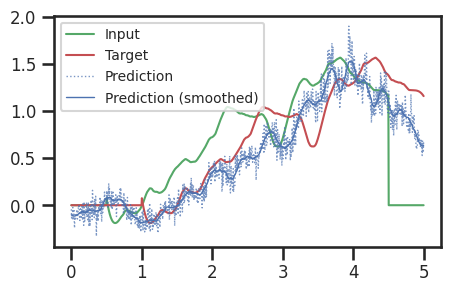

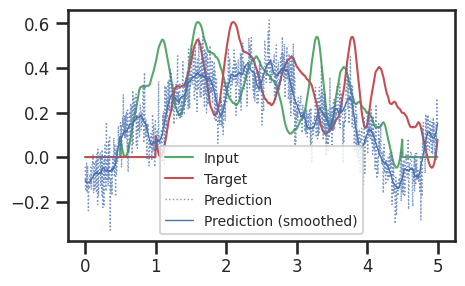

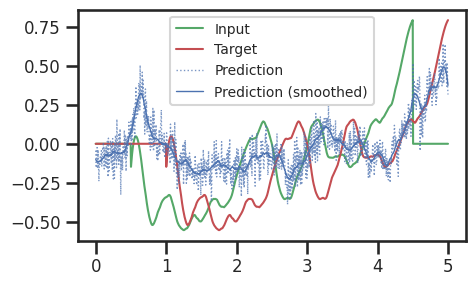

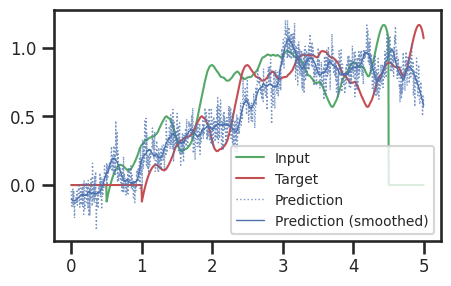

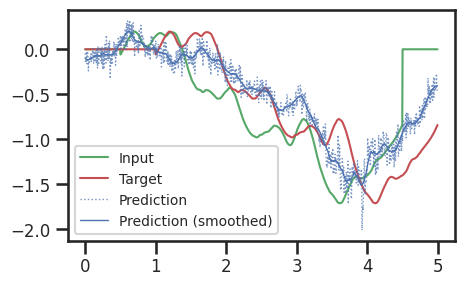

In [ ]:
''' training performance '''

x = np.arange(0, targets_delay[0].shape[0]) * dt

for idx in range(0,100,10):
    plt.figure(figsize=(5,3))
    
    prediction = spikingmodel_delay.predict(inputs_delay[idx])
    pred_smooth = signal.savgol_filter(x=prediction[:,0], window_length=steps+1, polyorder=3)
    
    plt.plot(x, inputs_delay[idx], color='g', label='Input', linewidth=1.5)
    plt.plot(x, targets_delay[idx], color='r', label='Target', linewidth=1.5)
    plt.plot(x, prediction, color='b',label='Prediction', linewidth=1, alpha=0.75, linestyle=":")
    plt.plot(x, pred_smooth, color='b',label='Prediction (smoothed)', linewidth=1)

    plt.legend()
    plt.show()
